Exercise description
--------------------

In the context of Mercadolibre's Marketplace an algorithm is needed to
predict if an item listed in the markeplace is new or used.

Your task to design a machine learning model to predict if an item is new or
used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k.jsonlines` and a
function to read that dataset in `build_dataset`.

For the evaluation you will have to choose an appropiate metric and also
elaborate an argument on why that metric was chosen.

The deliverables are:
- This file including all the code needed to define and evaluate a model.
- A text file with a short explanation on the criteria applied to choose the metric and the performance achieved on that metric.



## I. Importing libraries

In [1]:
import json, re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## II. Loading (and modifying) the dataset
Added two lines to avoid data leakage

In [2]:
def build_dataset():
    data = [json.loads(x) for x in open("../ml_evaluation/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    # NOTE: adding these lines to avoid data leakage
    for x in X_train:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = build_dataset()

#### Checking shapes and structure

In [4]:
len(X_train), len(y_train), len(X_test), len(y_test)

(90000, 90000, 10000, 10000)

In [5]:
X_train[0]

{'seller_address': {'comment': '',
  'longitude': -58.3986709,
  'id': 78162842,
  'country': {'name': 'Argentina', 'id': 'AR'},
  'address_line': '',
  'latitude': -34.6280698,
  'search_location': {'neighborhood': {'name': 'San Cristóbal',
    'id': 'TUxBQlNBTjkwNTZa'},
   'state': {'name': 'Capital Federal', 'id': 'TUxBUENBUGw3M2E1'},
   'city': {'name': 'Capital Federal', 'id': 'TUxBQ0NBUGZlZG1sYQ'}},
  'zip_code': '',
  'city': {'name': 'San Cristóbal', 'id': 'TUxBQlNBTjkwNTZa'},
  'state': {'name': 'Capital Federal', 'id': 'AR-C'}},
 'warranty': None,
 'sub_status': [],
 'seller_contact': None,
 'deal_ids': [],
 'base_price': 80,
 'shipping': {'local_pick_up': True,
  'methods': [],
  'tags': [],
  'free_shipping': False,
  'mode': 'not_specified',
  'dimensions': None},
 'non_mercado_pago_payment_methods': [{'description': 'Transferencia bancaria',
   'id': 'MLATB',
   'type': 'G'},
  {'description': 'Acordar con el comprador', 'id': 'MLAWC', 'type': 'G'},
  {'description': 'Efe

In [6]:
y_train[0]

'new'

In [7]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

print('train')
display(y_train.value_counts(normalize=True))
print('\ntest')
display(y_test.value_counts(normalize=True))

train


new     0.537244
used    0.462756
dtype: float64


test


new     0.5406
used    0.4594
dtype: float64

In [8]:
[x for x in X_train[0].keys()]

['seller_address',
 'warranty',
 'sub_status',
 'seller_contact',
 'deal_ids',
 'base_price',
 'shipping',
 'non_mercado_pago_payment_methods',
 'seller_id',
 'variations',
 'location',
 'site_id',
 'listing_type_id',
 'price',
 'attributes',
 'buying_mode',
 'tags',
 'listing_source',
 'parent_item_id',
 'coverage_areas',
 'category_id',
 'descriptions',
 'last_updated',
 'international_delivery_mode',
 'pictures',
 'id',
 'official_store_id',
 'differential_pricing',
 'accepts_mercadopago',
 'original_price',
 'currency_id',
 'thumbnail',
 'title',
 'automatic_relist',
 'date_created',
 'secure_thumbnail',
 'stop_time',
 'status',
 'video_id',
 'catalog_product_id',
 'subtitle',
 'initial_quantity',
 'start_time',
 'permalink',
 'geolocation',
 'sold_quantity',
 'available_quantity']

## III. General Analysis of features
We take a general overview to the dataset in order to find relevant relationships.

In [9]:
X_train = pd.DataFrame(X_train)
y_train.name = 'condition'

df = pd.concat([X_train, y_train], axis=1)

df['condition'] = df['condition'].map({'new':1, 'used':0})

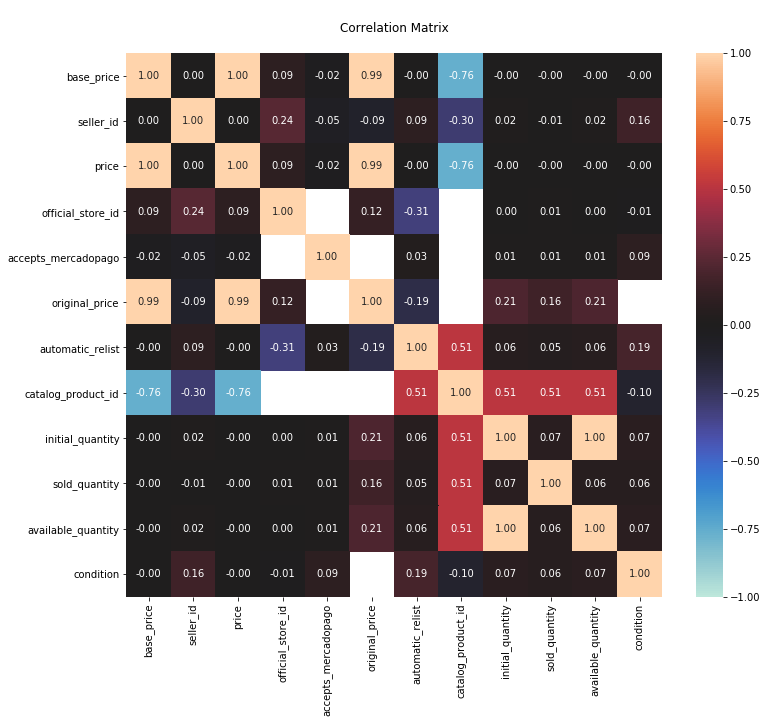

In [10]:
plt.figure(figsize=(12,10))
plt.title('\nCorrelation Matrix\n')
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='icefire');

## IV. Feature analysis
We'll explore each feature given in order to check wether they are worthy or not to be used in the model.

In [11]:
X_train.head()

,seller_address,warranty,sub_status,seller_contact,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,...,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,geolocation,sold_quantity,available_quantity
0,"{'comment': '', 'longitude': -58.3986709, 'id'...",None,[],None,[],80.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",74952096,[],...,active,None,NaN,None,1,2015-09-05T20:42:53.000Z,http://articulo.mercadolibre.com.ar/MLA-578052...,"{'latitude': -34.6280698, 'longitude': -58.398...",0,1
1,"{'comment': '', 'longitude': -58.5059173, 'id'...",NUESTRA REPUTACION,[],None,[],2650.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",42093335,[],...,active,None,NaN,None,1,2015-09-26T18:08:30.000Z,http://articulo.mercadolibre.com.ar/MLA-581565...,"{'latitude': -34.5935524, 'longitude': -58.505...",0,1
2,"{'comment': '', 'longitude': -58.4143948, 'id'...",None,[],None,[],60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",133384258,[],...,active,None,NaN,None,1,2015-09-09T23:57:07.000Z,http://articulo.mercadolibre.com.ar/MLA-578780...,"{'latitude': -34.6233907, 'longitude': -58.414...",0,1
3,"{'comment': '', 'longitude': -58.4929208, 'id'...",None,[],None,[],580.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",143001605,[],...,active,None,NaN,None,1,2015-09-28T18:47:56.000Z,http://articulo.mercadolibre.com.ar/MLA-581877...,"{'latitude': -34.6281894, 'longitude': -58.492...",0,1
4,"{'comment': '', 'longitude': -58.5495042, 'id'...",MI REPUTACION.,[],None,[],30.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",96873449,[],...,active,None,NaN,None,1,2015-08-24T22:07:20.000Z,http://articulo.mercadolibre.com.ar/MLA-576112...,"{'latitude': -34.6346547, 'longitude': -58.549...",0,1


### A. Warranty

In [12]:
X_train['warranty'].value_counts()

Sí                                                                                                                                                                          5107
Sin garantía                                                                                                                                                                4907
SI                                                                                                                                                                           545
6 meses                                                                                                                                                                      489
6 MESES                                                                                                                                                                      361
                                                                                                                   

We check if there are differences between ads with text in `warranty` or not.

In [13]:
print(f"% of ads with no text: {X_train['warranty'].isna().sum()/90_000}")
print(f"% of ads with text: {X_train['warranty'].notna().sum()/90_000}")

% of ads with no text: 0.6084111111111111
% of ads with text: 0.3915888888888889


In [14]:
mask = X_train.loc[X_train['warranty'].notna()].index
y_train.loc[mask].value_counts(normalize=True)

new     0.620747
used    0.379253
Name: condition, dtype: float64

In [15]:
mask = X_train.loc[X_train['warranty'].isna()].index
y_train.loc[mask].value_counts(normalize=True)

used    0.5165
new     0.4835
Name: condition, dtype: float64

#### Result
It can be observed that there is a difference between publications that have some text in the `warranty` key to those that do not.
Some RegEx might be helpful to find the differences between new and used products.

In [16]:
flaky = re.compile(
    'reputa[cs]i|calif|confian|calidad|satis?f|confor|total|experi|trayector|' +
    'prueb|nuevo|retir|revis|comprom|caract|falla',
    re.IGNORECASE
)

yes = re.compile('s[iíÍI]|d[iíIÍ]as?|a[ñÑ]os?|mes(es)?|f[aáAÁ]brica|' +
                 'vendedor|\bcon\sgara',
                 re.IGNORECASE)

no = re.compile('\bno|\bsin|usado|Sin garantía', re.IGNORECASE)

In [17]:
X_train['warranty'].str.contains(no, na=False).sum()\
+ X_train['warranty'].str.contains(flaky, na=False).sum()\
+ X_train['warranty'].str.contains(yes, na=False).sum()\
+ X_train['warranty'].str.contains('', na=False).sum()\
+ X_train['warranty'].isna().sum()

E:\Miniconda3\envs\ds37\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


129051

### B. Sub Status

In [18]:
mask = X_train['sub_status'].apply(lambda x: True if x else False)
y_train.loc[mask].value_counts(normalize=True)

new     0.553311
used    0.446689
Name: condition, dtype: float64

In [19]:
y_train.loc[~mask].value_counts(normalize=True)

new     0.537084
used    0.462916
Name: condition, dtype: float64

#### Result
No significant differences found. The feature should be deleted.

### C. Deal IDs

In [20]:
mask = X_train['deal_ids'].apply(lambda x: True if x else False)

display(y_train.loc[mask].value_counts(normalize=True))
print()
display(y_train.loc[~mask].value_counts(normalize=True))

new     0.981567
used    0.018433
Name: condition, dtype: float64

new     0.536171
used    0.463829
Name: condition, dtype: float64

In [21]:
X_train['deal_ids'].apply(lambda x: x[0] if x else np.nan).dropna().value_counts()

MLA58    55
MLA69    36
MLA4     36
MLA60    35
MLA70    29
MLA3     12
MLA25     6
MLA99     5
MLA17     2
MLA68     1
Name: deal_ids, dtype: int64

#### Result
Even though there are not many ads with content here, the difference can be appreciated. Esentially, if a publication has a deal, it's most likely a new product.

### D. Prices
We'll check both base price and original price in order to find any relationship with the product's condition.

In [22]:
X_train[['base_price', 'original_price', 'price']]

,base_price,original_price,price
0,80.00,NaN,80.00
1,2650.00,NaN,2650.00
2,60.00,NaN,60.00
3,580.00,NaN,580.00
4,30.00,NaN,30.00
...,...,...,...
89995,68.00,NaN,68.00
89996,126.00,NaN,126.00
89997,300.00,NaN,300.00
89998,696.58,NaN,696.58


In [23]:
df['has_original_price'] = df['original_price'].notna().astype(int)

In [24]:
df.corr()['condition'][['base_price', 'has_original_price', 'price']]

base_price           -0.000965
has_original_price    0.035298
price                -0.000965
Name: condition, dtype: float64

#### Result
Prices don't seem relevant in the analysis

### E. Shipping

In [25]:
shipping = pd.DataFrame(df['shipping'].to_dict()).T
df = pd.concat([df, shipping], axis=1)

In [26]:
df.loc[:, shipping.columns.to_list()].dtypes

local_pick_up    object
methods          object
tags             object
tags             object
free_shipping    object
mode             object
dimensions       object
free_methods     object
dtype: object

In [27]:
df.loc[:, shipping.columns.to_list()]

,local_pick_up,methods,tags,tags,free_shipping,mode,dimensions,free_methods
0,True,[],[dragged_bids_and_visits],[],False,not_specified,None,NaN
1,True,[],[],[],False,me2,None,NaN
2,True,[],[dragged_bids_and_visits],[],False,me2,None,NaN
3,True,[],[],[],False,me2,None,NaN
4,True,[],[dragged_bids_and_visits],[],False,not_specified,None,NaN
...,...,...,...,...,...,...,...,...
89995,False,[],[dragged_bids_and_visits],[],False,me2,None,NaN
89996,True,[],[dragged_bids_and_visits],[],False,custom,None,NaN
89997,True,[],[dragged_bids_and_visits],[],False,not_specified,None,NaN
89998,False,[],[dragged_bids_and_visits],[],False,not_specified,None,NaN


In [28]:
df['local_pick_up'] = df['local_pick_up'].astype(int)
df['free_shipping'] = df['free_shipping'].astype(int)

In [29]:
df['free_methods'].notna().sum()

2689

In [30]:
df.loc[df['free_methods'].notna(), 'free_methods'].apply(lambda x: x[0].get('id')).value_counts()

73328     2642
73330       37
501145       6
501146       4
Name: free_methods, dtype: int64

In [31]:
df['free_methods'].mask(df['free_methods'].isna(), lambda x: x[0].get('id') if isinstance(x, list) else np.nan)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
89995    NaN
89996    NaN
89997    NaN
89998    NaN
89999    NaN
Name: free_methods, Length: 90000, dtype: object

In [32]:
df.loc[df['free_methods'].notna(), 'free_methods'] = df.loc[
        df['free_methods'].notna(), 'free_methods']\
        .apply(lambda x: x[0].get('id'))

In [33]:
df.groupby('free_methods')['condition'].value_counts()

free_methods  condition
73328         1            2449
              0             193
73330         1              35
              0               2
501145        1               6
501146        1               4
Name: condition, dtype: int64

In [34]:
df.loc[df['methods'].fillna(False).apply(lambda x: True if x else False), 'methods']

Series([], Name: methods, dtype: object)

In [35]:
tags = df['tags'].copy()
tags.columns = ['tags1', 'tags2']
df.drop(columns=['tags'], inplace=True)
df = pd.concat([df, tags], axis=1)

In [36]:
df['tags1'] = df['tags1'].apply(lambda x: x[0] if x else np.nan)
df['tags1'].value_counts()

dragged_bids_and_visits    65315
good_quality_thumbnail      1537
dragged_visits               723
poor_quality_thumbnail        13
Name: tags1, dtype: int64

In [37]:
df.groupby('tags1')['condition'].value_counts(normalize=True)

tags1                    condition
dragged_bids_and_visits  1            0.529388
                         0            0.470612
dragged_visits           0            0.749654
                         1            0.250346
good_quality_thumbnail   1            0.886792
                         0            0.113208
poor_quality_thumbnail   1            1.000000
Name: condition, dtype: float64

In [38]:
df['tags2'] = df['tags2'].apply(lambda x: x[0] if x else np.nan)
df['tags2'].value_counts()

relisted_with_modifications    50
free_method_upgraded            9
Name: tags2, dtype: int64

In [39]:
df.groupby('tags2')['condition'].value_counts(normalize=True)

tags2                        condition
free_method_upgraded         1            1.00
relisted_with_modifications  1            0.64
                             0            0.36
Name: condition, dtype: float64

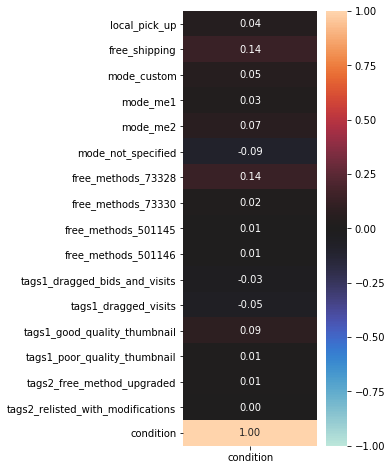

In [40]:
shipping = pd.get_dummies(df[['local_pick_up', 'free_shipping',  'mode', 'free_methods', 'tags1', 'tags2']])
shipping = pd.concat([shipping, df['condition']], axis=1)

plt.figure(figsize=(3,8))
sns.heatmap(shipping.corr()[['condition']], vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='icefire');

#### Result
Some weak correlations appear to be found in variables related to shipping.

### F. Descriptions

In [41]:
X_train['descriptions'].apply(lambda x: x[0].get('id') if x else np.nan).value_counts()

MLA576117780-903001885    1
MLA578786691-916491686    1
MLA576324730-903989739    1
MLA583257024-938679811    1
MLA583219321-938531138    1
                         ..
MLA576614284-905370380    1
MLA582652627-935943298    1
MLA580655533-926061379    1
MLA583591094-940136569    1
MLA583202208-938451967    1
Name: descriptions, Length: 87583, dtype: int64

#### Result
Description does not contain useful information, it's just an ID.

### G. Attributes

In [42]:
mask = df['attributes'].apply(lambda x: True if x else False)
print(mask.sum())
df.loc[mask, 'attributes'].apply(len).value_counts().head(10)

11150


2     7651
1     1366
65     783
14     161
3      141
50     101
6       99
52      99
13      93
9       57
Name: attributes, dtype: int64

In [43]:
display(df.loc[mask, 'condition'].value_counts(normalize=True))
print()
display(df.loc[~mask, 'condition'].value_counts(normalize=True))

1    0.598834
0    0.401166
Name: condition, dtype: float64

1    0.528535
0    0.471465
Name: condition, dtype: float64

In [44]:
att = df.loc[mask, 'attributes'].explode()
att = pd.DataFrame(att.to_list(), index=att.index)

In [45]:
att

,value_id,attribute_group_id,name,value_name,attribute_group_name,id
8,,DFLT,Número de pieza,37123,Otros,PART_NUMBER
9,female,DFLT,Género,Mujer,Otros,GENDER
9,Season-Spring-Summer,FIND,Season,Spring-Summer,Ficha técnica,Season
12,,DFLT,Número pieza,2,Otros,MLA-PART_NUMBER
13,female,DFLT,Género,Mujer,Otros,GENDER
...,...,...,...,...,...,...
89991,Season-All-Season,DFLT,Season,All-Season,Otros,Season
89994,female,DFLT,Género,Mujer,Otros,GENDER
89994,Season-All-Season,DFLT,Season,All-Season,Otros,Season
89999,female,DFLT,Género,Mujer,Otros,GENDER


#### Result
Attributes appear to add too much dimentionality and not much information. The fact that are present show a slight difference between conditions.

### H. Listing Type ID

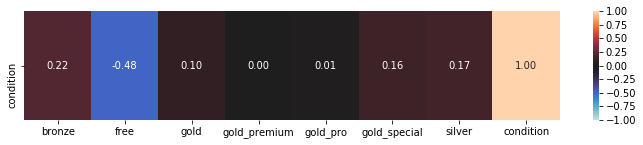

In [46]:
plt.figure(figsize=(12,2))
sns.heatmap(
    pd.get_dummies(df['listing_type_id'])\
    .join(df['condition'])\
    .corr()[['condition']].T,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    cmap='icefire'
);

### I. Non MercadoPago Payment Methods

In [47]:
df['alt_pmts'] = df['non_mercado_pago_payment_methods'].apply(
    lambda x: [y.get('description') for y in x] if x else None
)

In [48]:
pmt = []
[pmt.extend(x) for x in df['alt_pmts'].dropna().to_list()]
pmt = set(pmt)
pmt

{'Acordar con el comprador',
 'American Express',
 'Cheque certificado',
 'Contra reembolso',
 'Diners',
 'Efectivo',
 'Giro postal',
 'MasterCard',
 'Mastercard Maestro',
 'MercadoPago',
 'Tarjeta de crédito',
 'Transferencia bancaria',
 'Visa',
 'Visa Electron'}

In [49]:
df['alt_pmts']

0        [Transferencia bancaria, Acordar con el compra...
1                       [Transferencia bancaria, Efectivo]
2        [Transferencia bancaria, Tarjeta de crédito, E...
3        [Transferencia bancaria, Tarjeta de crédito, E...
4        [Transferencia bancaria, Acordar con el compra...
                               ...                        
89995                                                 None
89996                   [Transferencia bancaria, Efectivo]
89997                                           [Efectivo]
89998                           [Acordar con el comprador]
89999                                                 None
Name: alt_pmts, Length: 90000, dtype: object

In [50]:
def payment_mapper(pmt_list):
    result = pd.Series(0, index=pmt)
    if pmt_list:
        result[pmt_list] = 1
    return result

In [51]:
payments = df['alt_pmts'].apply(payment_mapper)

In [52]:
payments.head()

,Acordar con el comprador,Contra reembolso,Transferencia bancaria,Mastercard Maestro,Diners,American Express,Tarjeta de crédito,Giro postal,Cheque certificado,MercadoPago,MasterCard,Efectivo,Visa,Visa Electron
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [53]:
credit_cards = ['American Express', 'MasterCard', 'Diners', 'Visa']

debit_cards = ['Mastercard Maestro', 'Visa Electron']

payments['credit_cards'] = payments[credit_cards].sum(axis=1)

payments['debit_cards'] = payments[debit_cards].sum(axis=1)

In [54]:
payments.loc[(payments['Tarjeta de crédito']==0) \
             & (payments['credit_cards']==1),
            'Tarjeta de crédito'] = 1

In [55]:
payments = payments.drop(columns= debit_cards + credit_cards + ['credit_cards'])

In [56]:
df = df.join(payments)

In [57]:
payments.columns.to_list() + ['condition']

['Acordar con el comprador',
 'Contra reembolso',
 'Transferencia bancaria',
 'Tarjeta de crédito',
 'Giro postal',
 'Cheque certificado',
 'MercadoPago',
 'Efectivo',
 'debit_cards',
 'condition']

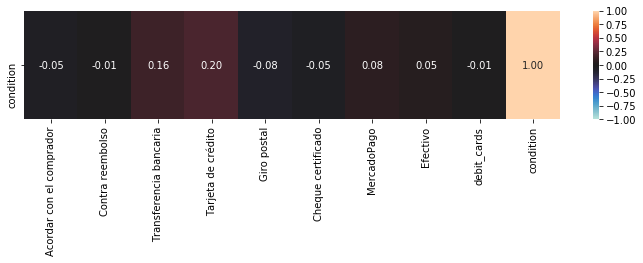

In [58]:
plt.figure(figsize=(12,2))
sns.heatmap(
    df[payments.columns.to_list() + ['condition']]\
    .corr()[['condition']].T,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    cmap='icefire'
);

#### Result
Paying methods appear to add information.

### J. Buying Mode

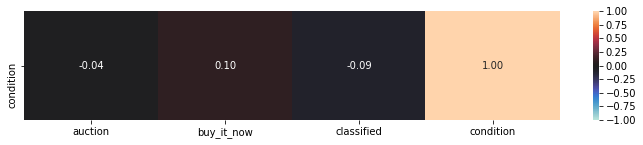

In [59]:
plt.figure(figsize=(12,2))
sns.heatmap(
    pd.get_dummies(df['buying_mode'])\
    .join(df['condition'])\
    .corr()[['condition']].T,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    cmap='icefire'
);

#### Result
Butying mode appears to add information.

### K. International Delivery

In [1]:
df['international_delivery_mode'].value_counts()

NameError: name 'df' is not defined

#### Result
International Delivery does not have relevant information.

### L. Accepts Mercadopago

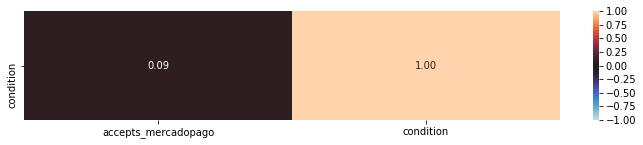

In [61]:
plt.figure(figsize=(12,2))
sns.heatmap(
    df[['accepts_mercadopago', 'condition']].astype(int)\
    .corr()[['condition']].T,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f',
    cmap='icefire'
);

----------------
## Title

In order to check for information in the Title, we are going to create a vector representation of the text and then reduce the dimensionallity with a Singular Value Decomposition.

In [217]:
df['title']

0        Auriculares Samsung Originales Manos Libres Ca...
1        Cuchillo Daga Acero Carbón Casco Yelmo Solinge...
2              Antigua Revista Billiken, N° 1826, Año 1954
3        Alarma Guardtex Gx412 Seguridad Para El Automo...
4                                Serenata - Jennifer Blake
                               ...                        
89995    El Fin De Las Libertades - Benegas Lynch (h) -...
89996              Honda Wave Guardabarro Interior Trasero
89997          My Little Pony Completa Latino 4 Temporadas
89998    Accidente Cerebrovascular En La Infancia Y Ado...
89999                    Campera De Mujer Tucci Reversible
Name: title, Length: 90000, dtype: object

In [63]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier
)
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [64]:
pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('dim', None),
        ('model', BernoulliNB())
    ]
)

In [92]:
params = [
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range': [(1,1), (1,3)],
        'dim': [TruncatedSVD()],
        'dim__n_components': [10, 100],
        'model': [BernoulliNB()],
        'model__alpha': [0.01, 0.1, 1]
    }
]

In [93]:
kf = KFold(3, shuffle=True)

grid = GridSearchCV(pipe, params, 'accuracy', n_jobs=-1, cv=kf, verbose=10)

In [76]:
X1, X2, y1, y2 = train_test_split(X_train, y_train, shuffle=True, stratify=y_train, test_size=.35)

In [78]:
X1.shape, X2.shape

((58500, 47), (31500, 47))

In [94]:
grid.fit(X2['title'], y2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.6min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ng

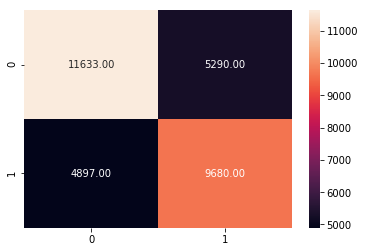

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
y_hat_train = grid.predict(X2['title'])

sns.heatmap(
    confusion_matrix(y2, y_hat_train),
    annot = True,
    fmt='.2f'
)

In [96]:
print(classification_report(y2, y_hat_train))

              precision    recall  f1-score   support

         new       0.70      0.69      0.70     16923
        used       0.65      0.66      0.66     14577

    accuracy                           0.68     31500
   macro avg       0.68      0.68      0.68     31500
weighted avg       0.68      0.68      0.68     31500



In [97]:
grid.best_params_

{'dim': TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
              random_state=None, tol=0.0),
 'dim__n_components': 100,
 'model': BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True),
 'model__alpha': 1,
 'vect': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 'vect__ngram_range': (1, 1)}

## Conclusion

We have some features that appear to add information as well as the title. For this reson, we'll create a `sklearn.pipeline.Pipeline` with all the required transformations for each set of columns as well as all the features from the text in order to combine them.